# Background

This notebook tries to find some interesting statistics based on the corona data available at [risklayer.com](http://www.risklayer.com/de/).

## A tentative first model of the data

Initially, it seems reasonable to expect the case-number $n$ to follow a logarithmic model - but we'll see if the data can really support that. 

A logarithmic expansion rate might look like this:
$$ \frac{dn}{dt} = \alpha(t) \left( 1 - \frac{n}{n_{tot}} \right) t $$

Note that $\alpha(t)$ depends on $t$, too.
It's value will change with the anti-corona meassures taken.

It'll also be interesting to see if we can use some spatial (like data from neighboring Landkreise) or temporal (like ARIMA) predictors.

But before we get ahead of ourselves, we'll need to do some much simpler analysis.

In [1]:
# Loading data

import pandas as p
import geopandas as gp

timeData = p.read_csv('data/GermanyValues.csv', index_col='Name_old')
globalData = p.read_csv('data/Germany_20200321v2.csv', index_col='Name_old')
percentage65 = p.read_csv('data/bevoelkerung_ueber_65.csv', index_col='Name', sep=';')
kreise = gp.read_file('data/landkreise.geojson')

In [36]:
# Preparing data

merged = globalData.join(percentage65)
merged = merged.rename(columns={'Wert': 'Perc65'})
merged['PercDead'] = merged.Dead / merged.Cumulative
merged = merged.dropna()

# Warm up: simple linear regression

For starters, we do a simple linear regression. 
It seems reasonable to assume that the mortality is predicted in part by the percentage of older people.

0.005421861919036375

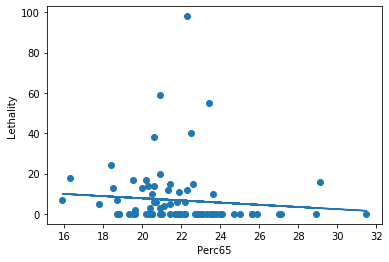

In [59]:
import sklearn as sk
import matplotlib.pyplot as plt



def linReg(indep, dep):
    X = merged[[indep]]
    Y = merged[dep]
    X_train, X_test, Y_train, Y_test = sk.model_selection.train_test_split(X, Y)
    model = sk.linear_model.LinearRegression()
    reg = model.fit(X_train, Y_train)
    score = model.score(X_test, Y_test)

    Y_prd = model.predict(X_test)
    plt.scatter(X_test, Y_test)
    plt.plot(X_test, Y_prd)
    plt.xlabel(indep)
    plt.ylabel(dep)

    return score


indepVar = 'Perc65'
depVar = 'Lethality'
score = linReg(indepVar, depVar)
score

## Linreg: Conclusions
Remarkably, the percentage of people over 65 years does not seem to be a good predictor for mortality or lethality.

# Looking for relationships in data

After finding `perc65` not a good predictor of mortality, we'll take a step back to see what kind of correlations we can find at all.


In [60]:
data = merged[['Population', 'Density', 'Mortality', 'Perc65', 'Cumulative']]
corr = data.corr()
corr.style.background_gradient(cmap='coolwarm')

,Population,Density,Mortality,Perc65,Cumulative
Population,1.000000,0.084140,-0.042446,-0.236169,0.824589
Density,0.084140,1.000000,0.629041,-0.345247,0.476533
Mortality,-0.042446,0.629041,1.000000,-0.106505,0.164357
Perc65,-0.236169,-0.345247,-0.106505,1.000000,-0.319248
Cumulative,0.824589,0.476533,0.164357,-0.319248,1.000000


## Relationships: conclusions

Mortality is quite strongly correlated with density.

0.29050899817566844

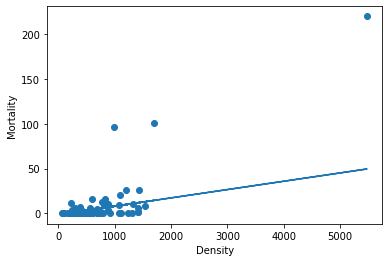

In [61]:
score = linReg('Density', 'Mortality')
score